In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
import os
import pickle
import cloudpickle

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys  
sys.path.append(os.getcwd())

In [2]:
fileset = {
    'ggH125': '/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18/GluGluHToZZTo4L_M125_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8/merged.root',
    'HC_3FS': '/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18/HPlusCharm_3FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnlo_JHUGenV7011_pythia8/merged.root',
    'HC_4FS': '/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18/HPlusCharm_4FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnlo_JHUGenV7011_pythia8/merged.root',
    'HC_4FSFxFx': '/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18/HPlusCharm_4FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnloFXFX_JHUGenV7011_pythia8/merged.root',
}
lumi = 59.83 * 1e3

arr, arr1 = {}, {}
for sam in fileset:
    arr[sam] = uproot.lazy(fileset[sam]+':Ana/passedEvents')
    arr1[sam] = uproot.lazy(f'/home/pku/licq/cH/zz_v2/samples/gen_training_dataset/v1/{sam}.root')

    arr[sam]['gen_sum_weights'] = uproot.open(fileset[sam]+':Ana/sumWeights').to_numpy()[0][0]
    arr[sam]['weight'] = arr[sam].eventWeight * lumi / arr[sam]['gen_sum_weights']
    if sam.startswith('HC_'):
        arr[sam]['weight'] = arr[sam]['weight'] / 1000.

In [3]:
for sam in ['ggH125', 'HC_4FSFxFx']:
    print(sam)
    # optimal disc training scores
    arr[sam]['score_is_hc_gen'] = uproot.lazy(f'/data/pku/home/licq/cH/zz_v2/selection/weaver/training/gen/20220625-225317_example_ParticleNet_969219f51b50b9c3779c93d9b56e28a0_ranger_lr0.01_batch512try1/predict_output/pred_{sam}_0.root').score_is_hc
    arr[sam]['score_is_hc_unclean'] = uproot.lazy(f'/data/pku/home/licq/cH/zz_v2/selection/weaver/training/reco/20220625-230620_example_ParticleNet_4d97d391db5ad22f0789e080fd4b00d3_ranger_lr0.01_batch512try1/predict_output/pred_{sam}_0.root').score_is_hc
    arr[sam]['score_is_hc'] = uproot.lazy(f'/data/pku/home/licq/cH/zz_v2/selection/weaver/training/reco_cleanobj/20220620-074218_example_ParticleNet_4d97d391db5ad22f0789e080fd4b00d3_ranger_lr0.01_batch512try1/predict_output/pred_{sam}_0.root').score_is_hc
    # BDT scores
    arr[sam]['bdtscore_jetge1'] = uproot.lazy(f'/data/pku/home/licq/cH/zz_v2/samples/bdt/hig0628/jetge1/{sam}.root').score
    arr[sam]['bdtscore_jet0_svge1'] = uproot.lazy(f'/data/pku/home/licq/cH/zz_v2/samples/bdt/hig0628/jet0_svge1/{sam}.root').score

ggH125
HC_4FSFxFx


# Make basic ROCs

In [4]:
def roc_maker(preselection, name, custom_roc={}):
    sig, bkg = 'HC_4FSFxFx', 'ggH125'
    d = {}
    for sam in [sig, bkg]:
        d[sam] = arr[sam][eval(preselection)]
    sum_weight = [sum(d[sig].weight), sum(d[bkg].weight)]

    f, ax = plt.subplots(figsize=(10,10))

    # contour lines
    n_x, n_y = sum_weight
    x = np.linspace(0., 1., 50)
    y = np.logspace(-4, 0, 50)
    X, Y = np.meshgrid(x, y)
    NX, NY = X * n_x, Y * n_y
    sigNY = 0.063 * NY
    Z1 = np.sqrt(2 * ((NX+NY) * np.log((NX+NY)*(NY+sigNY**2) / (NY**2 + (NX+NY)*sigNY**2)) - (NY/sigNY)**2 * np.log(1 + sigNY**2 * NX / (NY * (NY + sigNY**2)))))
    # Z1 = NX / np.sqrt(NY)
    CS = ax.contour(X, Y, Z1, levels=np.linspace(0.2*n_x/np.sqrt(n_y), 2*n_x/np.sqrt(n_y), 20), alpha=0.5)
    ax.clabel(CS, inline=True, fontsize=10)

    # GEN disc.
    fpr_gen, tpr_gen = [], []
    for score in np.linspace(0, 1, 51):
        tpr_gen.append(sum(d[sig][d[sig].score_is_hc_gen > score].weight) / sum_weight[0])
        fpr_gen.append(sum(d[bkg][d[bkg].score_is_hc_gen > score].weight) / sum_weight[1])
    # reco disc. uncleaned object
    fpr_unc, tpr_unc = [], []
    for score in np.linspace(0, 1, 51):
        tpr_unc.append(sum(d[sig][d[sig].score_is_hc_unclean > score].weight) / sum_weight[0])
        fpr_unc.append(sum(d[bkg][d[bkg].score_is_hc_unclean > score].weight) / sum_weight[1])
    # reco disc. cleaned object
    fpr, tpr = [], []
    for score in np.linspace(0, 1, 51):
        tpr.append(sum(d[sig][d[sig].score_is_hc > score].weight) / sum_weight[0])
        fpr.append(sum(d[bkg][d[bkg].score_is_hc > score].weight) / sum_weight[1])

    ax.plot([0,1], [0,1], color='grey', ls=':')
    ax.scatter(tpr_gen, fpr_gen, label='optimal GEN disc.')
    ax.scatter(tpr_unc, fpr_unc, label='optimal RECO (uncleaned) disc.')
    ax.scatter(tpr, fpr, label='optimal RECO disc.')
    ax.legend(prop={'size': 20})
    ax.set_xlim(0,1); ax.set_ylim(1e-4, 1e0); ax.set_yscale('log')
    ax.set_xlabel(r'Signal (H+c) eff.', ha='right', x=1.0); ax.set_ylabel('BKG (ggH) eff.', ha='right', y=1.0)
    ax.tick_params(axis='both', which='both', top=False, right=False)

    secax = ax.secondary_xaxis('top', functions=(lambda t: t*n_x, lambda t: t/n_x))
    secax.set_xlabel('Signal (H+c) yield', fontsize=20)
    secax = ax.secondary_yaxis('right', functions=(lambda t: t*n_y, lambda t: t/n_y))
    secax.set_ylabel('BKG (ggH) yield', fontsize=20)

    with open(f"../plots/gen_roc/{name}.cpkl", "wb") as file:
        cloudpickle.dump((f, ax), file)

In [5]:
preselections = {
    'jetge1': '(arr[sam].passedFullSelection) & (arr1[sam].ncleanedjet>0)',
    'jetge2': '(arr[sam].passedFullSelection) & (arr1[sam].ncleanedjet>=2)',
    'jet0': '(arr[sam].passedFullSelection) & (arr1[sam].ncleanedjet==0)', 
    'jet0_svge1': '(arr[sam].passedFullSelection) & (arr1[sam].ncleanedjet==0) & (arr1[sam].ncleanedsv>0)', 
    'jet0_svge2': '(arr[sam].passedFullSelection) & (arr1[sam].ncleanedjet==0) & (arr1[sam].ncleanedsv>=2)', 
    'jet0_sv0': '(arr[sam].passedFullSelection) & (arr1[sam].ncleanedjet==0) & (arr1[sam].ncleanedsv==0)', 
    'svge1': '(arr[sam].passedFullSelection) & (arr1[sam].ncleanedsv>0)', 
    'svge2': '(arr[sam].passedFullSelection) & (arr1[sam].ncleanedsv>=2)', 
}

## Step-1 basic ROC with standard training

In [43]:
# ROC curve
# for name in preselections:
    # roc_maker(preselections[name], name)

for name in ['svge1', 'svge2', 'jet0_svge2']:
    roc_maker(preselections[name], name)

## Step-2 additional ROC

In [6]:
rout_name, rootpath = 'pfcands', '/data/pku/home/licq/cH/zz_v2/selection/weaver/training/reco_pfcands/20220630-160542_example_ParticleNet_658cbbc8a98c8a8cd4b4d2408b7de667_ranger_lr0.005_batch256try2'
rout_name, rootpath = 'pfcandsonly', '/data/pku/home/licq/cH/zz_v2/selection/weaver/training/reco_pfcandsonly/20220704-212318_example_ParticleNet_969219f51b50b9c3779c93d9b56e28a0_ranger_lr0.005_batch256try1'
rout_name, rootpath = 'pfcands_LorentzNet', '/data/pku/home/licq/cH/zz_v2/selection/weaver/training/reco_pfcands/20220705-020426_example_LorentzNet_658cbbc8a98c8a8cd4b4d2408b7de667_ranger_lr0.002_batch64LorentzNet_try1'


## optimal disc for RECO with pfcandidates
arr_pf, arr1_pf = {}, {}
for sam in ['HC_4FSFxFx', 'ggH125']:
    arr_pf[sam] = uproot.lazy(fileset[sam].replace('MC_UL18', 'MC_UL18_addPFCands_try3')+':Ana/passedEvents')
    arr1_pf[sam] = uproot.lazy(f'/home/pku/licq/cH/zz_v2/samples/gen_training_dataset/v2-pfcands/{sam}.root')

    arr_pf[sam]['gen_sum_weights'] = uproot.open(fileset[sam].replace('MC_UL18', 'MC_UL18_addPFCands_try3')+':Ana/sumWeights').to_numpy()[0][0]
    arr_pf[sam]['weight'] = arr_pf[sam].eventWeight * lumi / arr_pf[sam]['gen_sum_weights']
    if sam.startswith('HC_'):
        arr_pf[sam]['weight'] = arr_pf[sam]['weight'] / 1000.

    # optimal disc training scores
    arr_pf[sam]['score_is_hc_pfcands'] = uproot.lazy(f'{rootpath}/predict_output/pred_{sam}_0.root').score_is_hc
 
for name in preselections:
    print(name)
    preselection = preselections[name].replace('arr[', 'arr_pf[').replace('arr1[', 'arr1_pf[')
    
    sig, bkg = 'HC_4FSFxFx', 'ggH125'
    d = {}
    for sam in [sig, bkg]:
        d[sam] = arr_pf[sam][eval(preselection)]
    sum_weight = [sum(d[sig].weight), sum(d[bkg].weight)]

    fpr, tpr = [], []
    for score in np.linspace(0, 1, 51):
        tpr.append(sum(d[sig][d[sig].score_is_hc_pfcands > score].weight) / sum_weight[0])
        fpr.append(sum(d[bkg][d[bkg].score_is_hc_pfcands > score].weight) / sum_weight[1])
    with open(f"../plots/gen_roc/{name}_{rout_name}_rates.cpkl", "wb") as file:
        cloudpickle.dump((tpr, fpr), file)

jetge1
jetge2
jet0
jet0_svge1
jet0_svge2
jet0_sv0
svge1
svge2


# Study custom selections

## Jet category

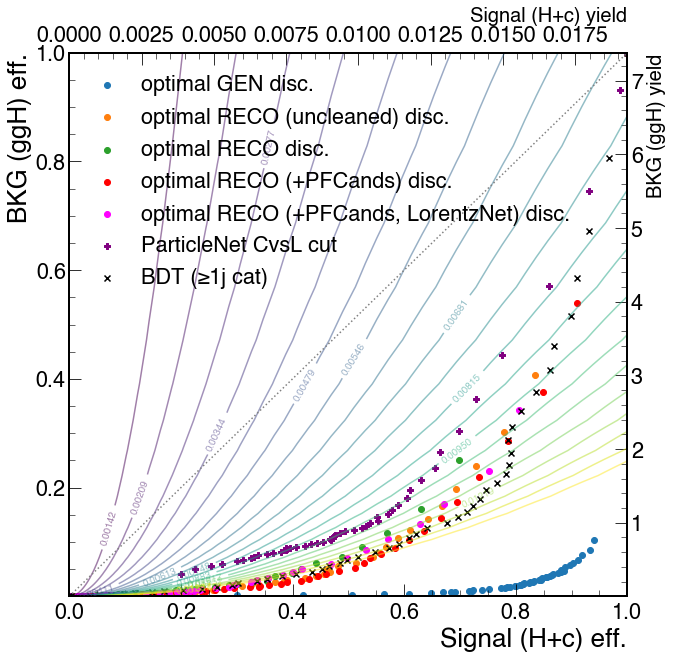

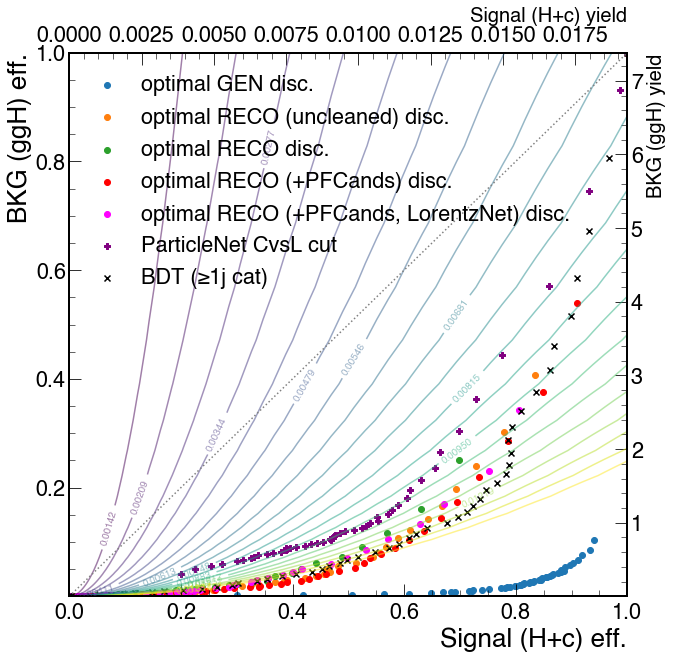

In [10]:
def show_figure(fig):
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)

name = 'jetge1'
name = 'jetge2'
with open(f"../plots/gen_roc/{name}.cpkl", "rb") as f:
    f, ax = cloudpickle.load(f)
show_figure(f)
ax.set_yscale('linear')

# custom plots
sig, bkg = 'HC_4FSFxFx', 'ggH125'
d, d1 = {}, {}
for sam in [sig, bkg]:
    d[sam] = arr[sam][eval(preselections[name])]
    d1[sam] = arr1[sam][eval(preselections[name])]
sum_weight = [sum(d[sig].weight), sum(d[bkg].weight)]

### optimal disc.
with open(f"../plots/gen_roc/{name}_pfcands_rates.cpkl", "rb") as file:
    tpr_pfcand, fpr_pfcand = cloudpickle.load(file)
ax.scatter(tpr_pfcand, fpr_pfcand, label='optimal RECO (+PFCands) disc.', color='red')

# with open(f"../plots/gen_roc/{name}_pfcandsonly_rates.cpkl", "rb") as file:
#     tpr_pfcand, fpr_pfcand = cloudpickle.load(file)
# ax.scatter(tpr_pfcand, fpr_pfcand, label='optimal RECO (only PFCands) disc.', color='magenta')

with open(f"../plots/gen_roc/{name}_pfcands_LorentzNet_rates.cpkl", "rb") as file:
    tpr_pfcand, fpr_pfcand = cloudpickle.load(file)
ax.scatter(tpr_pfcand, fpr_pfcand, label='optimal RECO (+PFCands, LorentzNet) disc.', color='magenta')

###
max_score = {}
for sam in [sig, bkg]:
    _score = d1[sam].cleanedjet_ParticleNet_CvsL
    max_score[sam] = ak.fill_none(_score.mask[d1[sam].ncleanedjet > 0][ak.singletons(ak.argmax(_score, axis=-1))][:,0], -1)

fpr_c, tpr_c = [], []
for score in np.linspace(0, 1, 51):
    tpr_c.append(sum(d[sig][max_score[sig] > score].weight) / sum_weight[0])
    fpr_c.append(sum(d[bkg][max_score[bkg] > score].weight) / sum_weight[1])
ax.scatter(tpr_c, fpr_c, label='ParticleNet CvsL cut', marker='P', color='purple')

###
fpr_c, tpr_c = [], []
for score in np.linspace(0, 1, 51):
    tpr_c.append(sum(d[sig][d[sig].bdtscore_jetge1 > score].weight) / sum_weight[0])
    fpr_c.append(sum(d[bkg][d[bkg].bdtscore_jetge1 > score].weight) / sum_weight[1])
ax.scatter(tpr_c, fpr_c, label='BDT (≥1j cat)', marker='x', color='black')

ax.legend()
plt.savefig(f'../plots/gen_roc/{name}_v4.pdf')

## SV category

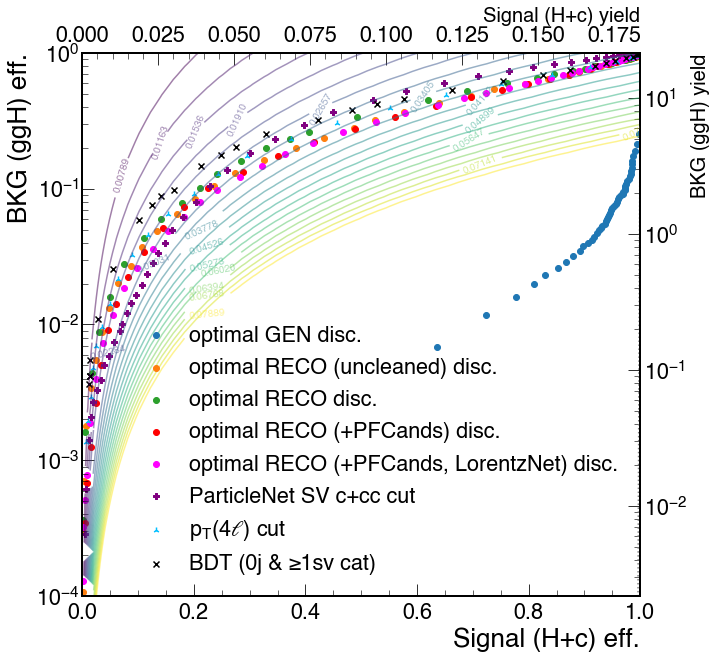

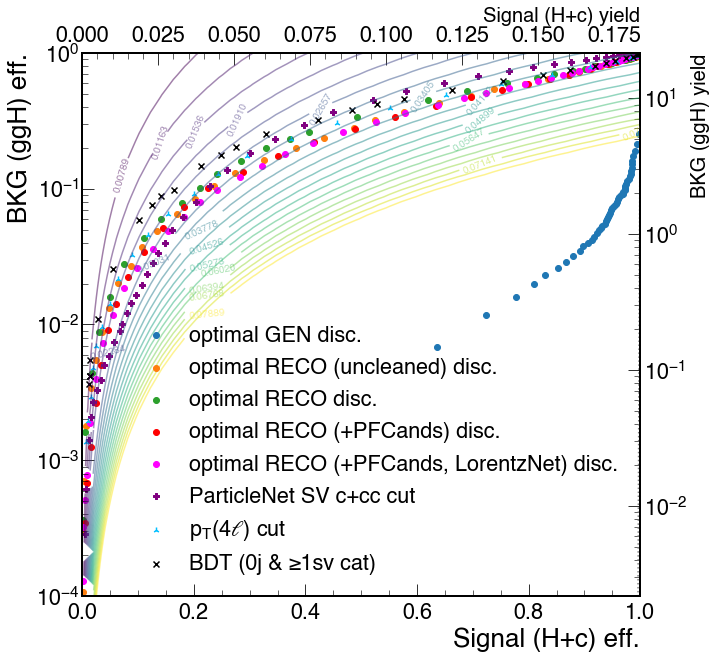

In [6]:
def show_figure(fig):
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)

name = 'jet0_svge1'
# name = 'jet0_svge2'
# name = 'svge1'
# name = 'svge2'
# name = 'jet0_sv0' # comment out pnet curve and bdt curve
# name = 'jet0' # comment out pnet curve and bdt curve

with open(f"../plots/gen_roc/{name}.cpkl", "rb") as f:
    f, ax = cloudpickle.load(f)
show_figure(f)
# ax.set_yscale('linear')

# custom plots
sig, bkg = 'HC_4FSFxFx', 'ggH125'
d, d1 = {}, {}
for sam in [sig, bkg]:
    d[sam] = arr[sam][eval(preselections[name])]
    d1[sam] = arr1[sam][eval(preselections[name])]
sum_weight = [sum(d[sig].weight), sum(d[bkg].weight)]

### optimal disc.
with open(f"../plots/gen_roc/{name}_pfcands_rates.cpkl", "rb") as file:
    tpr_pfcand, fpr_pfcand = cloudpickle.load(file)
ax.scatter(tpr_pfcand, fpr_pfcand, label='optimal RECO (+PFCands) disc.', color='red')

# with open(f"../plots/gen_roc/{name}_pfcandsonly_rates.cpkl", "rb") as file:
#     tpr_pfcand, fpr_pfcand = cloudpickle.load(file)
# ax.scatter(tpr_pfcand, fpr_pfcand, label='optimal RECO (only PFCands) disc.', color='magenta')

with open(f"../plots/gen_roc/{name}_pfcands_LorentzNet_rates.cpkl", "rb") as file:
    tpr_pfcand, fpr_pfcand = cloudpickle.load(file)
ax.scatter(tpr_pfcand, fpr_pfcand, label='optimal RECO (+PFCands, LorentzNet) disc.', color='magenta')

###
max_score = {}
for sam in [sig, bkg]:
    _score = d1[sam].cleanedsv_ParticleNet_c + d1[sam].cleanedsv_ParticleNet_cc
    max_score[sam] = ak.fill_none(_score.mask[d1[sam].ncleanedsv > 0][ak.singletons(ak.argmax(_score, axis=-1))][:,0], -1)
fpr_c, tpr_c = [], []
for score in np.linspace(0, 1, 51):
    tpr_c.append(sum(d[sig][max_score[sig] > score].weight) / sum_weight[0])
    fpr_c.append(sum(d[bkg][max_score[bkg] > score].weight) / sum_weight[1])
ax.scatter(tpr_c, fpr_c, label='ParticleNet SV c+cc cut', marker='P', color='purple')

###
fpr_c, tpr_c = [], []
for score in np.logspace(0, 4, 51):
    tpr_c.append(sum(d[sig][d[sig].pT4l < score].weight) / sum_weight[0])
    fpr_c.append(sum(d[bkg][d[bkg].pT4l < score].weight) / sum_weight[1])
ax.scatter(tpr_c, fpr_c, label=r'$p_{T}(4\ell)$ cut', marker='2', color='deepskyblue')

###
fpr_c, tpr_c = [], []
for score in np.linspace(0, 1, 51):
    tpr_c.append(sum(d[sig][d[sig].bdtscore_jetge1 > score].weight) / sum_weight[0])
    fpr_c.append(sum(d[bkg][d[bkg].bdtscore_jetge1 > score].weight) / sum_weight[1])
ax.scatter(tpr_c, fpr_c, label='BDT (0j & ≥1sv cat)', marker='x', color='black')

ax.legend()
# plt.savefig(f'../plots/gen_roc/{name}_v4.pdf')

# Standard plotter

In [3]:
def make_plot(title, nbin=50, xmin=70, xmax=170, kc=10, content_arr='arr[sam].ZZMass', weight_arr='arr[sam].weight', xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 2 GeV', 
        ylog=False, custom_bkg=None, custom_sig=None, custom_command=None, store_plot=False):

    f, ax = plt.subplots(figsize=(10, 10))
    hep.cms.label(data=True, llabel='Preliminary', year=2018, ax=ax, fontname='sans-serif') # llabel='Work in progress'

    plot_bkg_info = { # order is important
        'ggH125':  (r'$gg\to H$', 'lightpink'),
        # 'vbfh':  (r'EW $qqH$', 'thistle'),
        # 'vh':  (r'$VH$', 'hotpink'),
        # 'tth':  (r'$t\bar{t}H$', 'violet'),
        # 'bbh':  (r'$b\bar{b}H$', 'mediumorchid'),
        'qqzz': (r'$q\bar{q}\to ZZ,\,Z\gamma*$', 'lightskyblue'),
        'ggzz': (r'$gg\to ZZ,\,Z\gamma*$', 'royalblue'),
        'zx':   ('Z+X', 'green')
    }
    plot_sig_info = { # only allow one
        'HC_4FSFxFx':   ('H+c (4FS,FxFx) $(\kappa_c=%d)$', 'red', 'solid'),
        'HC_4FS':   ('H+c (4FS) $(\kappa_c=%d)$', 'violet', 'dashed'),
        'HC_3FS':   ('H+c (3FS) $(\kappa_c=%d)$', 'blueviolet', 'dashed'),
    }
    samlist_stack = list(plot_bkg_info.keys())[::-1]
    if custom_bkg is not None:
        samlist_stack = custom_bkg
    if custom_sig is not None:
        plot_sig_info = {k: plot_sig_info[k] for k in custom_sig}

    # get weighted boost histogram
    hist = {}
    for sam in set(plot_sig_info.keys()) | set(samlist_stack):
        print(sam)
        if isinstance(nbin, int):
            axis = bh.axis.Regular(nbin, xmin, xmax)
        else:
            axis = bh.axis.Variable(nbin)
        hist[sam] = bh.Histogram(axis, storage=bh.storage.Weight())
        hist[sam].fill(eval(content_arr), weight=eval(weight_arr)) # replace None value with 1e20
    hist_add = sum([hist[sam] for sam in samlist_stack])

    # make stacked plot
    hep.histplot(
        [hist[sam].view().value for sam in samlist_stack], 
        bins=hist_add.axes[0].edges,
        yerr=[np.sqrt(hist[sam].view().variance) for sam in samlist_stack],
        label=[plot_bkg_info[sam][0] for sam in samlist_stack], color=[plot_bkg_info[sam][1] for sam in samlist_stack], 
        histtype='fill', edgecolor='k', linewidth=1, stack=True,
    )

    # plot signal stat uncertainties
    bkgtot, bkgtot_err = hist_add.view(flow=False).value, np.sqrt(hist_add.view(flow=False).variance)
    ax.fill_between(hist_add.axes[0].edges, (bkgtot-bkgtot_err).tolist()+[0], (bkgtot+bkgtot_err).tolist()+[0], label='BKG stat. unce.', step='post', hatch='///', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

    for samsig in plot_sig_info:
        # plot signal
        hep.histplot(
            hist[samsig].view().value * kc**2,
            bins=hist_add.axes[0].edges,
            yerr=np.sqrt(hist[samsig].view().variance) * kc**2,
            label=plot_sig_info[samsig][0] % kc, color=plot_sig_info[samsig][1], #linestyle=plot_sig_info[samsig][2],
        )
#         print('sig', hist[samsig].view().value, 'bkgtot', hist_add.view().value, np.sqrt(2*np.sqrt(hist_add.view().value[0]) / hist[samsig].view().value[0]))
    ax.legend(prop={'size': 20}, ncol=2, labelspacing=0.3, borderpad=0.3)
    ax.set_xlabel(xlabel, ha='right', x=1.0); ax.set_ylabel(ylabel, ha='right', y=1.0);
    ax.set_xlim(xmin, xmax); ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    if ylog:
        ax.set_yscale('log')
    if custom_command is not None:
        exec(custom_command)
    
    if store_plot:
        store_dir = '../plots/histo_ggh_hc_0614/'
        plt.savefig(store_dir + f'/datamc_{title}.jpg')
        plt.savefig(store_dir + f'/datamc_{title}.pdf')


In [1]:
d = {}
for sam in fileset:
    d[sam] = arr[sam][(arr[sam].passedFullSelection)]
    
make_plot(title='mass4l', nbin=50, xmin=70, xmax=170, kc=10, 
    content_arr='d[sam].mass4l',
    weight_arr='d[sam].weight',
    xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 2 GeV', ylog=False, custom_bkg=['ggH125'],
    custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)",
    store_plot=False
)
# make_plot(title='D_bkg_kin', nbin=20, xmin=0, xmax=1, kc=10, 
#     content_arr='d[sam].D_bkg_kin',
#     weight_arr='d[sam].weight',
#     xlabel=r'$D_{bkg}^{kin}$', ylabel='Events / 0.05', ylog=False, custom_bkg=['ggH125'],
#     custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)",
#     store_plot=False
# )


NameError: name 'fileset' is not defined

ggH125
HC_3FS
HC_4FS
HC_4FSFxFx
ggH125
HC_4FSFxFx
HC_4FS
HC_3FS
ggH125
HC_4FSFxFx
HC_4FS
HC_3FS
ggH125
HC_4FSFxFx
HC_4FS
HC_3FS
ggH125
HC_4FSFxFx
HC_4FS
HC_3FS


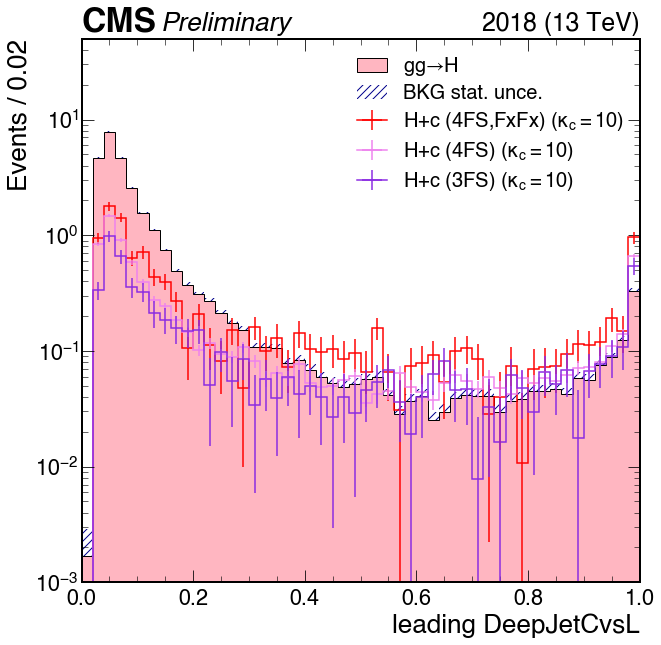

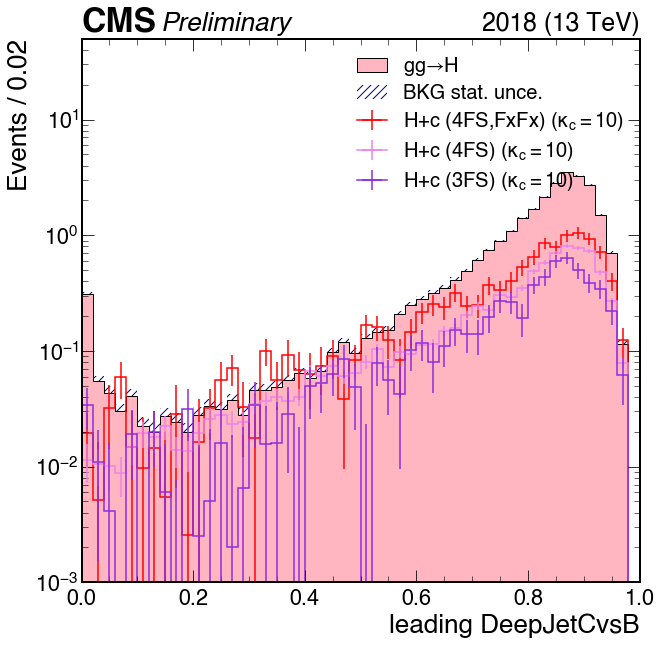

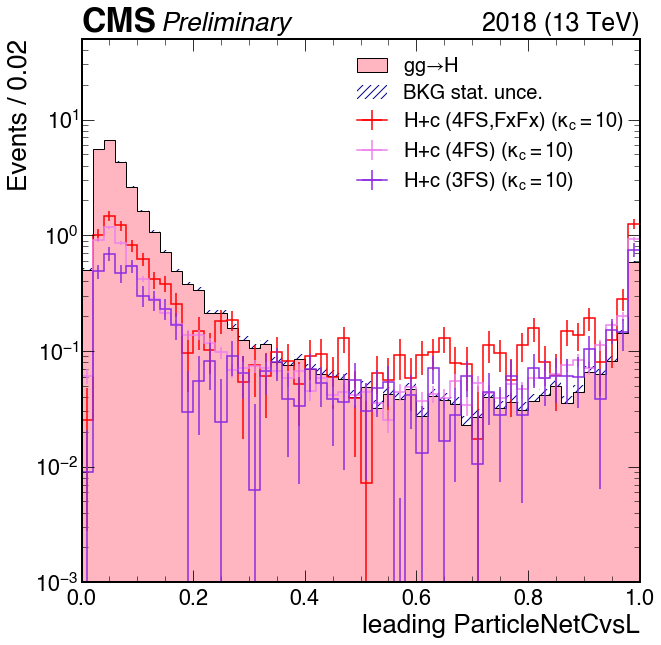

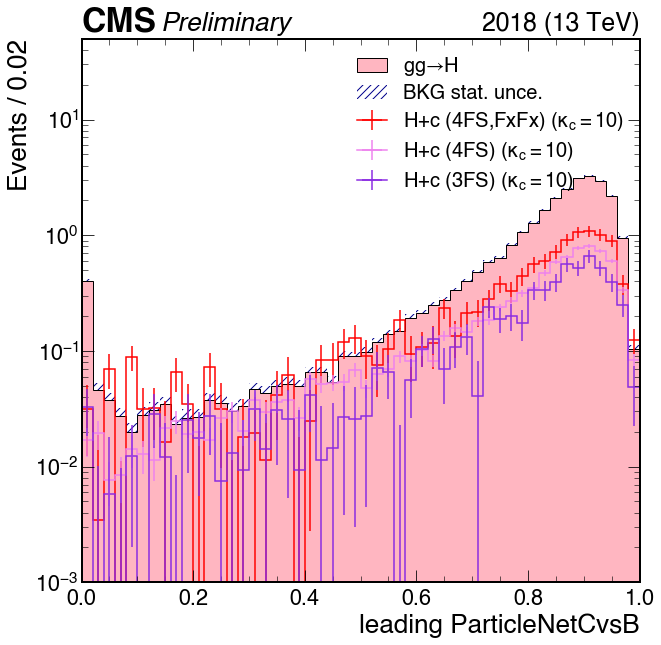

In [97]:
d = {}
dic = {sam: {} for sam in fileset}
for sam in fileset:
    print(sam)
    d[sam] = arr[sam][(arr[sam].passedFullSelection) & (arr[sam].mass4l>118) & (arr[sam].mass4l<130)]
    dic[sam]['cleanjet_pt'] = d[sam].jet_pt[d[sam].jet_iscleanH4l]
    dic[sam]['cleanjet_DeepJet_CvsL'] = d[sam].jet_DeepJet_CvsL[d[sam].jet_iscleanH4l]
    dic[sam]['cleanjet_DeepJet_CvsB'] = d[sam].jet_DeepJet_CvsB[d[sam].jet_iscleanH4l]
    dic[sam]['cleanjet_ParticleNet_CvsL'] = d[sam].jet_ParticleNet_CvsL[d[sam].jet_iscleanH4l]
    dic[sam]['cleanjet_ParticleNet_CvsB'] = d[sam].jet_ParticleNet_CvsB[d[sam].jet_iscleanH4l]

make_plot(title='jet_DeepJet_CvsL_leadCvsL', nbin=50, xmin=0, xmax=1, kc=10, 
    content_arr='ak.fill_none(dic[sam]["cleanjet_DeepJet_CvsL"].mask[ak.num(dic[sam]["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic[sam]["cleanjet_DeepJet_CvsL"], axis=-1))][:,0], -1)',
    weight_arr='d[sam].weight',
    xlabel=r'leading DeepJetCvsL', ylabel='Events / 0.02', ylog=True, custom_bkg=['ggH125'],
    custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)"
)

make_plot(title='jet_DeepJet_CvsB_leadCvsL', nbin=50, xmin=0, xmax=1, kc=10, 
    content_arr='ak.fill_none(dic[sam]["cleanjet_DeepJet_CvsB"].mask[ak.num(dic[sam]["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic[sam]["cleanjet_DeepJet_CvsL"], axis=-1))][:,0], -1)',
    weight_arr='d[sam].weight',
    xlabel=r'leading DeepJetCvsB', ylabel='Events / 0.02', ylog=True, custom_bkg=['ggH125'],
    custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)"
)

# make_plot(title='jet_DeepJet_CvsL_leadpt', nbin=50, xmin=0, xmax=1, kc=10, 
#     content_arr='ak.fill_none(dic[sam]["cleanjet_DeepJet_CvsL"].mask[ak.num(dic[sam]["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic[sam]["cleanjet_pt"], axis=-1))][:,0], -1)',
#     weight_arr='d[sam].weight',
#     xlabel=r'leading DeepJetCvsL', ylabel='Events / 0.02', ylog=True, custom_bkg=['ggH125'],
#     custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)"
# )

make_plot(title='jet_ParticleNet_CvsL_leadCvsL', nbin=50, xmin=0, xmax=1, kc=10, 
    content_arr='ak.fill_none(dic[sam]["cleanjet_ParticleNet_CvsL"].mask[ak.num(dic[sam]["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic[sam]["cleanjet_ParticleNet_CvsL"], axis=-1))][:,0], -1)',
    weight_arr='d[sam].weight',
    xlabel=r'leading ParticleNetCvsL', ylabel='Events / 0.02', ylog=True, custom_bkg=['ggH125'],
    custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)"
)

make_plot(title='jet_ParticleNet_CvsB_leadCvsL', nbin=50, xmin=0, xmax=1, kc=10, 
    content_arr='ak.fill_none(dic[sam]["cleanjet_ParticleNet_CvsB"].mask[ak.num(dic[sam]["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic[sam]["cleanjet_ParticleNet_CvsL"], axis=-1))][:,0], -1)',
    weight_arr='d[sam].weight',
    xlabel=r'leading ParticleNetCvsB', ylabel='Events / 0.02', ylog=True, custom_bkg=['ggH125'],
    custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)"
)



ggH125
HC_3FS
HC_4FS
HC_4FSFxFx
ggH125
HC_4FSFxFx
HC_4FS
HC_3FS


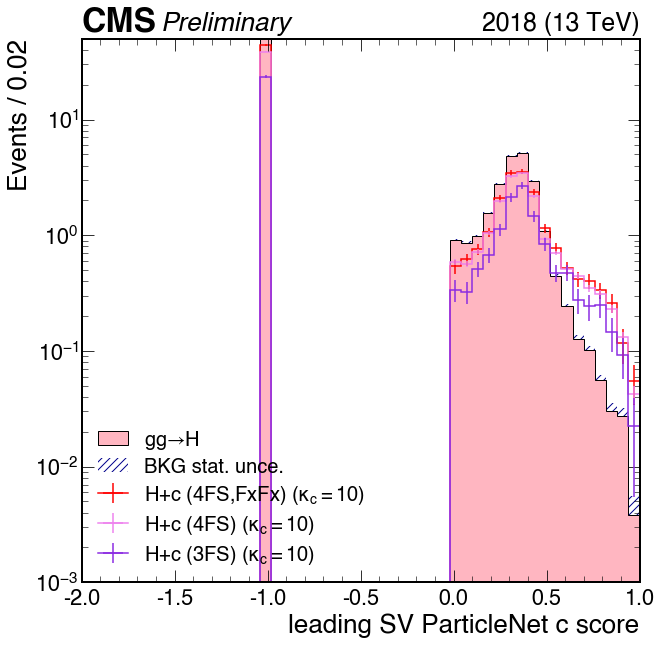

In [121]:
d = {}
dic = {sam: {} for sam in fileset}
for sam in fileset:
    print(sam)
    d[sam] = arr[sam][(arr[sam].passedFullSelection) & (arr[sam].mass4l>118) & (arr[sam].mass4l<130)]
    dic[sam]['cleanjet_pt'] = d[sam].jet_pt[d[sam].jet_iscleanH4l]

# for s in ['c', 'b', 'cc', 'bb', 'unmat']:
for s in ['c']:
    make_plot(title=f'sv_ParticleNet_{s}', nbin=50, xmin=-2, xmax=1, kc=10, 
        content_arr=f'ak.fill_none(d[sam]["sv_ParticleNet_{s}"].mask[(ak.num(dic[sam]["cleanjet_pt"])==0) & (ak.num(d[sam]["sv_pt"])>0)][ak.singletons(ak.argmax(d[sam]["sv_ParticleNet_c"], axis=-1))][:,0], -1)',
        weight_arr='d[sam].weight',
        xlabel=f'leading SV ParticleNet {s} score', ylabel='Events / 0.02', ylog=True, custom_bkg=['ggH125'],
        custom_command="ax.set_ylim(1e-3,5e1); ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)",
        store_plot=True
    )